Progetto: FROM SINGLE RGB TO STEREOSCOPIC IMAGE (predizione dell'obiettivo di destra da quello sinistro)

Prof: Nicola Felice Capece

Studenti: Gabriele Damiano 69292 Francescopio Pascale 69306

CELLA 1: Installazione e Importazione delle Librerie

In [14]:
!pip install tensorflow opencv-python numpy matplotlib scikit-image pillow gdown

In [94]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import gdown
import zipfile
from tqdm import tqdm 
import json
from tensorflow.keras.models import load_model
import random

CELLA 2: Scaricamento ed Estrazione del Dataset

In [ ]:
# Modificare questa variabile per cambiare la base del percorso (TuoPercorso è un placeholder)
base_dir = r'C:/TuoPercorso'  

In [ ]:
# ID del file su Google Drive e URL di download
file_id = "1My6oQaHzclxRrKID-mylvs6Z0d5pT_Cu"

def download_with_progress(url, output_path):
    with tqdm(total=100, desc="Scaricamento", unit='%', ncols=100) as pbar:
        gdown.download(url, output_path, quiet=False)
        pbar.update(100)  

# Funzione per scaricare ed estrarre il dataset
def download_and_extract_dataset(file_id, download_path, extract_path):
    if not os.path.exists(extract_path):
        os.makedirs(download_path, exist_ok=True)
        zip_path = os.path.join(download_path, "Flickr1024.zip")

        # Scarica il file zip da Google Drive
        print("Scaricamento del dataset da Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        download_with_progress(url, zip_path)  
        print("Scaricamento completato.")
        
        print("Estrazione del dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Estrazione completata.")
    else:
        print("Dataset già presente in locale.")

dataset_dir = os.path.join(base_dir, 'dataset', 'Flickr1024')
download_path = os.path.dirname(dataset_dir)  # Directory dove scaricare il file zip
extract_path = dataset_dir                    # Directory dove estrarre il dataset


download_and_extract_dataset(file_id, download_path, extract_path)


CELLA 3: Caricamento e Preprocessamento del Dataset

In [111]:
# Funzione per caricare e preprocessare le immagini
def load_image(image_path):
    image = cv2.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converte BGR in RGB
    image = cv2.resize(image, (256, 256))  # Ridimensiona l'immagine a 256x256 pixel
    image = image / 255.0  # Normalizza i valori dei pixel tra 0 e 1
    return image.astype(np.float32) 

# Funzione per caricare i percorsi delle immagini da ciascuna cartella
def load_data_from_split(base_dir, split):
    split_dir = os.path.join(base_dir, split)
    left_images = sorted([os.path.join(split_dir, img) for img in os.listdir(split_dir) if img.endswith('_L.png')])
    right_images = sorted([os.path.join(split_dir, img) for img in os.listdir(split_dir) if img.endswith('_R.png')])
    return left_images, right_images

# Caricamento delle immagini per ciascuna cartella
left_train, right_train = load_data_from_split(base_dir, 'Train')
left_val, right_val = load_data_from_split(base_dir, 'Validation')
left_test, right_test = load_data_from_split(base_dir, 'Test')

print(f"Train set: {len(left_train)} left images, {len(right_train)} right images")
print(f"Validation set: {len(left_val)} left images, {len(right_val)} right images")
print(f"Test set: {len(left_test)} left images, {len(right_test)} right images")

Train set: 800 left images, 800 right images
Validation set: 112 left images, 112 right images
Test set: 112 left images, 112 right images


CELLA 4: Creazione della Pipeline del Dataset

In [97]:
def preprocess(left_path, right_path):
    left_path = left_path.decode('utf-8')
    right_path = right_path.decode('utf-8')
    left_image = load_image(left_path)
    right_image = load_image(right_path)
    return left_image, right_image

def create_dataset(left_images, right_images):
    dataset = tf.data.Dataset.from_tensor_slices((left_images, right_images))
    
    # Applica la funzione di preprocessamento
    dataset = dataset.map(lambda x, y: tf.numpy_function(preprocess, [x, y], [tf.float32, tf.float32]))
    
    # Garantisce che ogni immagine abbia la forma corretta
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, [256, 256, 3]), 
                                        tf.ensure_shape(y, [256, 256, 3])))
    
    dataset = dataset.shuffle(buffer_size=1000)     
    dataset = dataset.batch(32)     
    dataset = dataset.repeat()  # Ripete i dati     
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Creazione dei dataset per training e validation
train_dataset = create_dataset(left_train, right_train)
val_dataset = create_dataset(left_val, right_val)

CELLA 5: Definizione dell'Architettura Encoder-Decoder

In [ ]:
# Combined loss function: SSIM + RMSE
def combined_ssim_rmse_loss(y_true, y_pred):
    # SSIM loss inversa
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    # RMSE loss
    rmse_loss = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    # Peso per bilanciare le metriche
    alpha = 0.3
    return alpha * ssim_loss + (1 - alpha) * rmse_loss

# Definizione del modello
def build_autoencoder(input_shape):
    # Encoder
    encoder_input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output values in range [0, 1]

    autoencoder = tf.keras.Model(encoder_input, decoded)
    return autoencoder


input_shape = (256, 256, 3)
autoencoder = build_autoencoder(input_shape)
optAdam = tf.keras.optimizers.Adam(learning_rate=1e-4)


autoencoder.compile(optimizer=optAdam, loss=combined_ssim_rmse_loss)


checkpoint_callback = ModelCheckpoint(
    'inserisci_nome_modello.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Addestramento
history = autoencoder.fit(
    train_dataset,
    epochs=30,
    steps_per_epoch=len(left_train) // 32,
    validation_data=val_dataset,
    validation_steps=len(left_val) // 32,
    callbacks=[checkpoint_callback, early_stopping]
)

# Salvataggio Loss 
def save_loss_plot(history, file_name_prefix='combined_loss_plot'):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{file_name_prefix}.png')
    plt.show()
    plt.close()


save_loss_plot(history, file_name_prefix='combined_loss_plot')

# Salvataggio modello addestrato corrente
autoencoder.save('inserisci_nome_modello.keras')

# Salvataggio dell'addestramento
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)



CELLA 6: Caricamento di un Modello già addestrato e della Cronologia di Addestramento

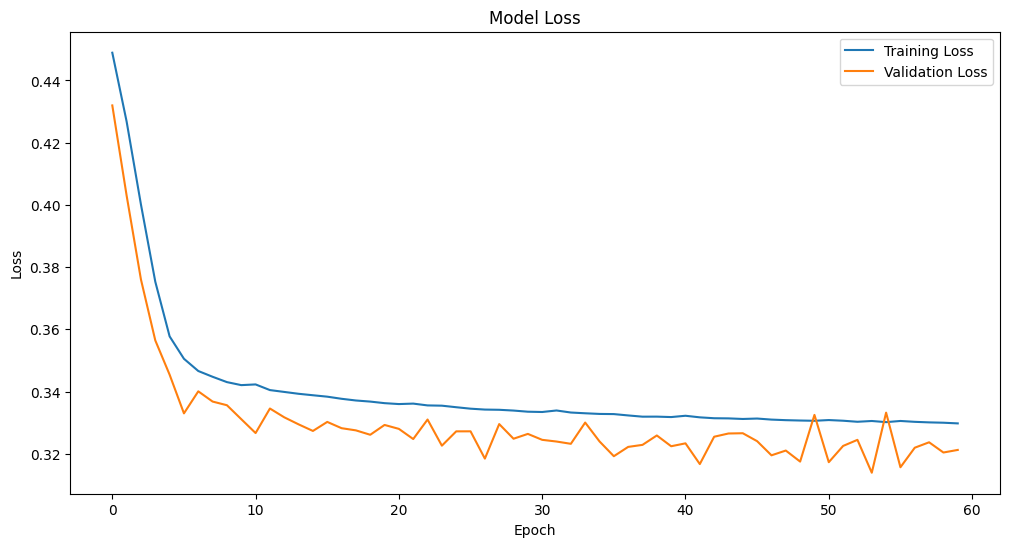

In [125]:
# NOTA BENE: complete_autoencoder_combined_ssim_rmse.keras fa riferimento al modello base utilizzato per testare il codice; è possibile scegliere 
#un nome a proprio piacimento per i modelli personali

@tf.keras.utils.register_keras_serializable()
def combined_ssim_rmse_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    rmse_loss = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    alpha = 0.3
    return alpha * ssim_loss + (1 - alpha) * rmse_loss

# Carica il modello completo
autoencoder = load_model('complete_autoencoder_combined_ssim_rmse.keras', custom_objects={'combined_loss': combined_ssim_rmse_loss})

# Carica la cronologia dell'addestramento
with open('training_history_combined_ssim_rmse.json', 'r') as f:
    history_data = json.load(f)

# Funzione per plottare la cronologia caricata
def plot_loaded_history(history_data):
    plt.figure(figsize=(12, 6))
    plt.plot(history_data['loss'], label='Training Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualizza il grafico della loss
plot_loaded_history(history_data)

CELLA 7: Visualizzazione dei Risultati

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


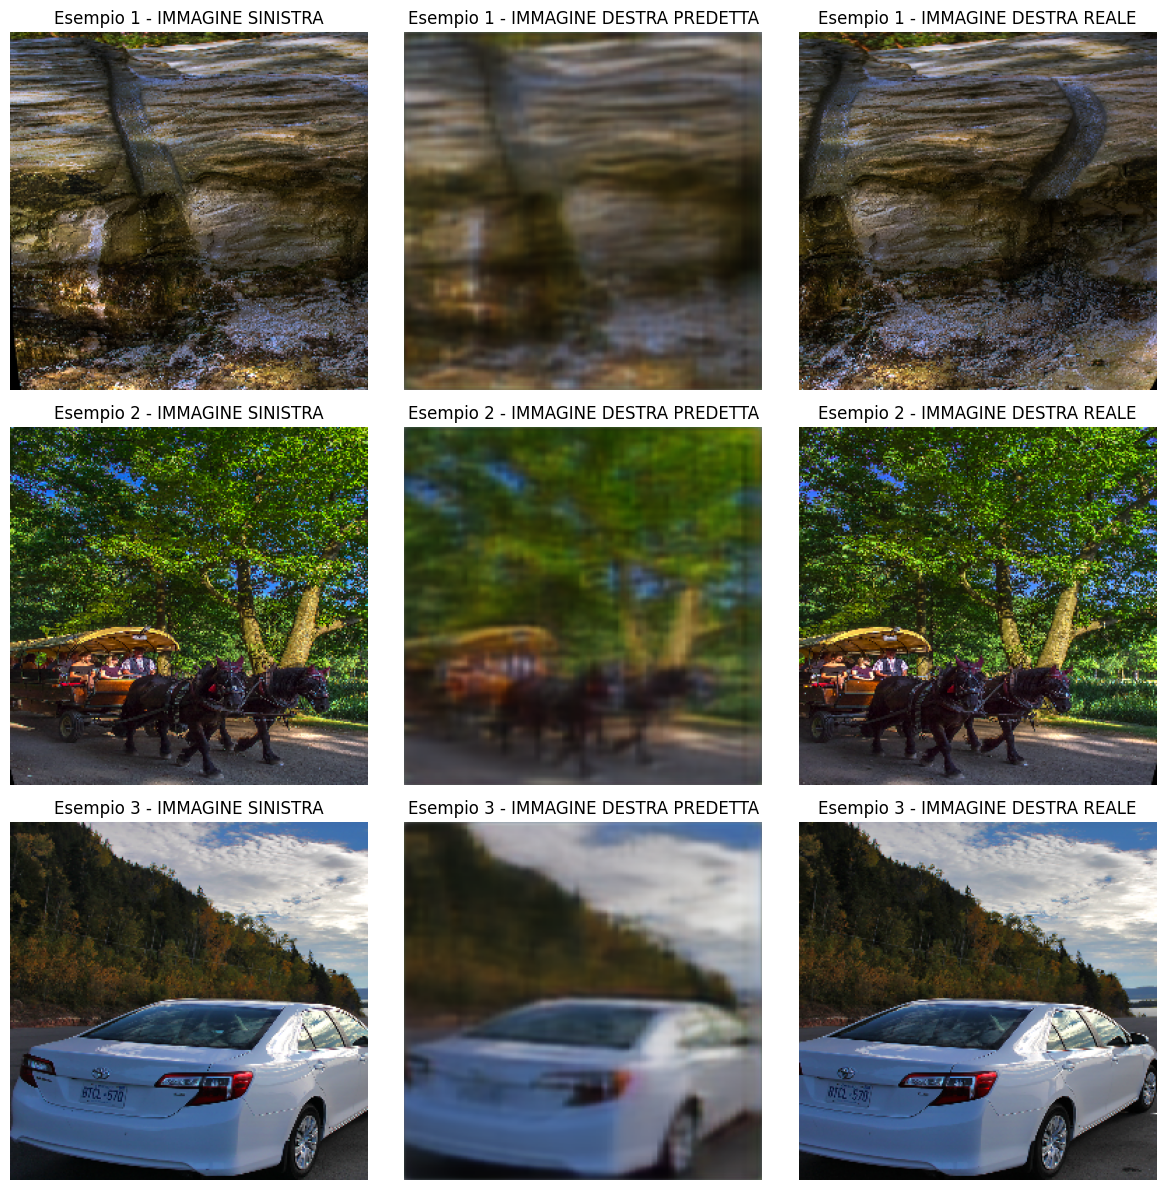

In [126]:
# Visualizzazione dei risultati di un campione
def display_samples(autoencoder, left_images, right_images, num_samples=3, save_path=None):
    random_indices = random.sample(range(len(left_images)), num_samples)

    plt.figure(figsize=(12, 4 * num_samples))
    
    for i, idx in enumerate(random_indices):
        left_image_path = left_images[idx]
        right_image_path = right_images[idx]

        # Carica l'immagine sinistra e quella reale destra
        left_image = load_image(left_image_path)
        right_image = load_image(right_image_path)

        # Espandi dimensione e predici l'immagine destra
        left_image_expanded = np.expand_dims(left_image, axis=0)
        predicted_image = autoencoder.predict(left_image_expanded)[0]
        predicted_image = np.clip(predicted_image, 0, 1)  # Limita i valori a [0, 1]

        # Denormalizza le immagini per la visualizzazione
        left_image_vis = (left_image * 255).astype(np.uint8)
        right_image_vis = (right_image * 255).astype(np.uint8)
        predicted_image_vis = (predicted_image * 255).astype(np.uint8)

        # Mostra le immagini
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f'Esempio {i+1} - IMMAGINE SINISTRA')
        plt.imshow(left_image_vis)
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f'Esempio {i+1} - IMMAGINE DESTRA PREDETTA')
        plt.imshow(predicted_image_vis)
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f'Esempio {i+1} - IMMAGINE DESTRA REALE')
        plt.imshow(right_image_vis)
        plt.axis('off')

    plt.tight_layout()
    
    # Salvataggio grafico
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)

    plt.show()

# Visualizza e salva tre campioni casuali
display_samples(autoencoder, left_val, right_val, num_samples=3, save_path="esempi_predizioni.png")


CELLA 8: Calcolo delle Metriche di Valutazione

In [ ]:
def evaluate_model(autoencoder, dataset, num_batches=None):
    mse_scores = []
    psnr_scores = []
    ssim_scores = []
    
    # Prende un subset del dataset (solo num_batches batch se specificato)
    dataset_to_evaluate = dataset.take(num_batches) if num_batches else dataset

    for batch_count, (left_images, right_images) in enumerate(dataset_to_evaluate, start=1):
        print(f"Processing batch {batch_count}...")  # Output del batch corrente

        # Previsione  dele immagini destre
        predicted_right_images = autoencoder.predict(left_images)


        right_images_np = right_images.numpy()
        predicted_right_images_np = predicted_right_images

        # Calcola le metriche per ogni immagine nel batch
        for true_image, pred_image in zip(right_images_np, predicted_right_images_np):
            # MSE
            mse = np.mean((true_image - pred_image) ** 2)
            mse_scores.append(mse)

            # PSNR
            psnr_value = psnr(true_image, pred_image, data_range=1.0)
            psnr_scores.append(psnr_value)

            # SSIM con controllo dinamico di win_size
            min_dimension = min(true_image.shape[0], true_image.shape[1])
            win_size = min(7, min_dimension)  # Finestra SSIM dinamica
            ssim_value = ssim(true_image, pred_image, channel_axis=-1, win_size=win_size, data_range=1.0)
            ssim_scores.append(ssim_value)
        
        # Feedback ogni 10 batch
        if batch_count % 10 == 0:
            print(f"Processati {batch_count} batch...")

    # Calcola i valori medi e massimi delle metriche
    avg_mse = np.mean(mse_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    max_mse = np.max(mse_scores)
    max_psnr = np.max(psnr_scores)
    max_ssim = np.max(ssim_scores)

    print("Valutazione completata.")
    return avg_mse, avg_psnr, avg_ssim, max_mse, max_psnr, max_ssim

avg_mse, avg_psnr, avg_ssim, max_mse, max_psnr, max_ssim = evaluate_model(autoencoder, val_dataset, num_batches=32)

print(f"MSE Medio: {avg_mse}")
print(f"PSNR Medio: {avg_psnr}")
print(f"SSIM Medio: {avg_ssim}")
print(f"MSE Massimo: {max_mse}")
print(f"PSNR Massimo: {max_psnr}")
print(f"SSIM Massimo: {max_ssim}")

CELLA 9: Salvataggio delle Metriche come Immagine

In [36]:
def save_metrics_as_table(metrics, file_name="evaluation_metrics.png"):
    """
    Salva le metriche di valutazione come immagine in formato tabellare.
    
    Parametri:
    - metrics: dizionario contenente i nomi delle metriche e i relativi valori.
    - file_name: nome del file immagine di output.
    """
    # Creazione della figura
    fig, ax = plt.subplots(figsize=(8, 2)) 

 
    metrics_data = [[key, f"{value:.4f}"] for key, value in metrics.items()]

    # Creazione dela tabella
    table = ax.table(cellText=metrics_data, colLabels=["Metrica", "Valore"], cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2) 
    ax.axis("off")

    # Salvataggio dela tabella come immagine
    plt.savefig(file_name, format="png", dpi=300)
    plt.close(fig)
    print(f"Tabella delle metriche salvata come {file_name}")

# Dizionario
metrics = {
    "MSE Medio": avg_mse,
    "PSNR Medio": avg_psnr,
    "SSIM Medio": avg_ssim,
    "MSE Massimo": max_mse,
    "PSNR Massimo": max_psnr,
    "SSIM Massimo": max_ssim
}

# Salvataggio metriche
save_metrics_as_table(metrics, file_name="evaluation_metrics_rmse_ssim.png")

Tabella delle metriche salvata come evaluation_metrics_rmse_ssim.png


CELLA 10: Predizione su Dati di Test

In [ ]:
def load_test_images(base_dir):
    test_dir = os.path.join(base_dir, 'Test')
    left_test_images = sorted([os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('_L.png')])
    return left_test_images
    
# Funzione di preprocessamento per il test (solo immagine sinistra)
def preprocess_test(left_path):
    left_path = left_path.decode('utf-8') 
    left_image = load_image(left_path)  # Carica l'immagine sinistra
    return tf.cast(left_image, tf.float32)

# Funzione per creare il dataset di test (solo immagini sinistre)
def create_test_dataset(left_images):
    test_dataset = tf.data.Dataset.from_tensor_slices(left_images)
    
    # Applica la funzione di preprocessamento solo per l'immagine sinistra
    test_dataset = test_dataset.map(lambda x: tf.numpy_function(preprocess_test, [x], [tf.float32]))
    
    test_dataset = test_dataset.map(lambda x: tf.ensure_shape(x, [256, 256, 3]))
    
    test_dataset = test_dataset.batch(16)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return test_dataset

left_test_images = load_test_images(base_dir)  # Carica le immagini di test
test_dataset = create_test_dataset(left_test_images)  # Crea il dataset di test

# Funzione per predire e visualizzare i risultati delle immagini di test
def predict_and_compare(model, test_dataset):
    for left in test_dataset.take(1): 
        predictions = model.predict(left)


        fig, axes = plt.subplots(3, 2, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.4, wspace=0.3)  

        for i in range(3):  # Mostra le prime 3 immagini
            # Immagine sinistra (reale)
            axes[i, 0].imshow(left[i].numpy())
            axes[i, 0].set_title('IMMAGINE SINISTRA')
            axes[i, 0].axis('off')

            # Immagine destra predetta
            axes[i, 1].imshow(predictions[i])
            axes[i, 1].set_title('IMMAGINE DESTRA PREDETTA')
            axes[i, 1].axis('off')

        plt.show()

predict_and_compare(autoencoder, test_dataset)

CELLA 11: Predizione su Immagini Esterne e Visualizzazione

In [ ]:
def load_and_preprocess_custom_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = cv2.resize(image, (256, 256))  
    image = image / 255.0 
    image = np.expand_dims(image, axis=0)  
    return image

# Funzione per eseguire la previsione e visualizzare i risultati su un'immagine esterna
def predict_on_custom_image(model, image_path):
    # Carica e preprocessa l'immagine esterna
    left_image = load_and_preprocess_custom_image(image_path)
    prediction = model.predict(left_image)[0]  # Ottieni la predizione per l'immagine

    # Denormalizza per la visualizzazione (da [0, 1] a [0, 255])
    left_image_vis = (left_image[0] * 255).astype(np.uint8)
    predicted_image_vis = np.clip(prediction * 255, 0, 255).astype(np.uint8)

    # Visualizza l'immagine originale e quella predetta
    plt.figure(figsize=(10, 5))

    # Immagine sinistra (originale)
    plt.subplot(1, 2, 1)
    plt.title('IMMAGINE SINISTRA (CUSTOM)')
    plt.imshow(left_image_vis)
    plt.axis('off')

    # Immagine destra predetta
    plt.subplot(1, 2, 2)
    plt.title('IMMAGINE DESTRA PREDETTA')
    plt.imshow(predicted_image_vis)
    plt.axis('off')

    plt.show()

# Esempio di utilizzo con una immagine esterna
custom_image_path = '/inserisci/percorso/immagine'  
predict_on_custom_image(autoencoder, custom_image_path)
